# Endpoint Regressor Validation

Validate saved endpoint-regressor predictions using parquet outputs and truth labels from the main data files.

This notebook does **not** run model inference.


In [1]:
import json
from datetime import datetime
from pathlib import Path

import numpy as np
import polars as pl
import torch

from pioneerml.common.zenml import utils as zenml_utils
from pioneerml.common.evaluation.plots import (
    plot_regression_diagnostics,
    plot_euclidean_error_histogram,
    plot_error_embedding_space,
)

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)

print(f"Project root: {PROJECT_ROOT}")


Using ZenML repository root: /workspace
Ensure this is the top-level of your repo (.zen must live here).
Project root: /workspace


## List Available Prediction Files

In [2]:
# List available saved endpoint-regressor prediction files
prediction_dir = Path(PROJECT_ROOT) / "data" / "endpoint_regressor"
prediction_files = sorted(prediction_dir.glob("*_preds.parquet"))
if not prediction_files:
    raise ValueError(f"No prediction parquet files found in {prediction_dir}")

print(f"Found {len(prediction_files)} prediction file(s).")
for i, p in enumerate(prediction_files[:10]):
    print(f"[{i}] {p.name}")


Found 5 prediction file(s).
[0] ml_output_000_preds.parquet
[1] ml_output_001_preds.parquet
[2] ml_output_002_preds.parquet
[3] ml_output_003_preds.parquet
[4] ml_output_004_preds.parquet


## Prediction Source

In [3]:
# Validation now loads predictions from parquet files (no model inference run in this notebook)
print("Validation mode: load existing predictions + truth from parquet files.")


Validation mode: load existing predictions + truth from parquet files.


## Load Validation Data

In [4]:
# Load validation parquet inputs and aligned endpoint prediction files

def _pick_pred(pred_dir: Path, main_path: Path) -> Path | None:
    candidates = [
        pred_dir / f"{main_path.stem}_preds.parquet",
        pred_dir / f"{main_path.stem}_preds_latest.parquet",
    ]
    for c in candidates:
        if c.exists():
            return c
    return None

main_dir = Path(PROJECT_ROOT) / "data"
main_paths = sorted(main_dir.glob("ml_output_*.parquet"))

# Example: uncomment to use a smaller subset
main_paths = main_paths[:1]

prediction_dir = Path(PROJECT_ROOT) / "data" / "endpoint_regressor"
paired = []
for mp in main_paths:
    pp = _pick_pred(prediction_dir, mp)
    if pp is not None:
        paired.append((str(mp.resolve()), str(pp.resolve())))

if not paired:
    raise RuntimeError(
        "No aligned main/endpoint prediction pairs found. "
        "Run endpoint-regressor inference first."
    )

parquet_paths = [p[0] for p in paired]
endpoint_pred_paths = [p[1] for p in paired]

print(f"Validation files: {len(parquet_paths)}")
for p in parquet_paths:
    print(" -", p)
print(f"Endpoint prediction files: {len(endpoint_pred_paths)}")


Validation files: 1
 - /workspace/data/ml_output_000.parquet
Endpoint prediction files: 1


## Load Predictions And Truth

In [5]:
# Load predictions from saved parquet outputs and build truth labels from main parquet files

QUANT_COL_ORDER = [
    "pred_group_start_x_q16", "pred_group_start_x_q50", "pred_group_start_x_q84",
    "pred_group_start_y_q16", "pred_group_start_y_q50", "pred_group_start_y_q84",
    "pred_group_start_z_q16", "pred_group_start_z_q50", "pred_group_start_z_q84",
    "pred_group_end_x_q16", "pred_group_end_x_q50", "pred_group_end_x_q84",
    "pred_group_end_y_q16", "pred_group_end_y_q50", "pred_group_end_y_q84",
    "pred_group_end_z_q16", "pred_group_end_z_q50", "pred_group_end_z_q84",
]
BASE_COL_ORDER = [
    "pred_group_start_x", "pred_group_start_y", "pred_group_start_z",
    "pred_group_end_x", "pred_group_end_y", "pred_group_end_z",
]

pred_blocks = []
target_blocks = []
pred_dim = None

for main_path, pred_path in zip(parquet_paths, endpoint_pred_paths, strict=True):
    pred_schema = pl.scan_parquet(pred_path).collect_schema().names()
    pred_cols = set(pred_schema)

    use_quant = all(c in pred_cols for c in QUANT_COL_ORDER)
    use_base = all(c in pred_cols for c in BASE_COL_ORDER)
    if not use_quant and not use_base:
        raise RuntimeError(f"Prediction file missing endpoint columns: {pred_path}")

    pred_col_order = QUANT_COL_ORDER if use_quant else BASE_COL_ORDER
    this_dim = 18 if use_quant else 6
    pred_dim = this_dim if pred_dim is None else pred_dim
    if this_dim != pred_dim:
        raise RuntimeError("Mixed endpoint prediction dimensions across files are not supported.")

    main_flat = (
        pl.scan_parquet(main_path)
        .select([
            "group_start_x", "group_start_y", "group_start_z",
            "group_end_x", "group_end_y", "group_end_z",
        ])
        .with_columns(
            pl.int_range(pl.len(), dtype=pl.UInt32).alias("row_idx"),
            pl.int_ranges(
                pl.lit(0),
                pl.col("group_start_x").list.len(),
                dtype=pl.UInt32,
            ).alias("time_group_id"),
        )
        .explode([
            "time_group_id",
            "group_start_x", "group_start_y", "group_start_z",
            "group_end_x", "group_end_y", "group_end_z",
        ])
        .filter(pl.col("time_group_id").is_not_null())
        .select(
            "row_idx",
            "time_group_id",
            pl.col("group_start_x").cast(pl.Float32),
            pl.col("group_start_y").cast(pl.Float32),
            pl.col("group_start_z").cast(pl.Float32),
            pl.col("group_end_x").cast(pl.Float32),
            pl.col("group_end_y").cast(pl.Float32),
            pl.col("group_end_z").cast(pl.Float32),
        )
        .collect()
    )

    pred_flat = (
        pl.scan_parquet(pred_path)
        .select(["time_group_ids", *pred_col_order])
        .with_columns(
            pl.int_range(pl.len(), dtype=pl.UInt32).alias("row_idx"),
            pl.int_ranges(
                pl.lit(0),
                pl.col("time_group_ids").list.len(),
                dtype=pl.UInt32,
            ).alias("pred_idx"),
        )
        .explode(["pred_idx", "time_group_ids", *pred_col_order])
        .filter(pl.col("pred_idx").is_not_null())
        .select(
            "row_idx",
            "pred_idx",
            pl.col("time_group_ids").cast(pl.UInt32).alias("time_group_id"),
            *[pl.col(c).cast(pl.Float32).alias(c) for c in pred_col_order],
        )
        .collect()
    )

    if main_flat.height == 0 and pred_flat.height == 0:
        continue

    joined = (
        pred_flat.join(main_flat, on=["row_idx", "time_group_id"], how="left")
        .sort(["row_idx", "pred_idx"])
    )
    if joined.height != pred_flat.height:
        raise RuntimeError(
            f"Endpoint alignment mismatch for {main_path} vs {pred_path} "
            f"(pred={pred_flat.height}, matched={joined.height})"
        )
    has_invalid_group_id = joined.select(
        pl.any_horizontal([
            pl.col("group_start_x").is_null(),
            pl.col("group_start_y").is_null(),
            pl.col("group_start_z").is_null(),
            pl.col("group_end_x").is_null(),
            pl.col("group_end_y").is_null(),
            pl.col("group_end_z").is_null(),
        ]).any().alias("has_null")
    ).item()
    if has_invalid_group_id:
        raise RuntimeError(f"Invalid time-group id(s) found while aligning {pred_path}")

    pred_np = joined.select(pred_col_order).to_numpy()
    base_target_np = joined.select([
        "group_start_x", "group_start_y", "group_start_z",
        "group_end_x", "group_end_y", "group_end_z",
    ]).to_numpy()
    target_np = np.repeat(base_target_np, repeats=3, axis=1) if pred_dim == 18 else base_target_np

    pred_blocks.append(pred_np.astype(np.float32, copy=False))
    target_blocks.append(target_np.astype(np.float32, copy=False))

if not pred_blocks:
    raise RuntimeError("No endpoint predictions found after loading parquet files.")

predictions = torch.from_numpy(np.concatenate(pred_blocks, axis=0).astype(np.float32, copy=False))
targets = torch.from_numpy(np.concatenate(target_blocks, axis=0).astype(np.float32, copy=False))

metrics_latest = (Path(PROJECT_ROOT) / "data" / "endpoint_regressor" / "metrics_latest.json")
export_info = {
    "predictions_paths": endpoint_pred_paths,
    "metrics_path": str(metrics_latest) if metrics_latest.exists() else None,
}

print("Loaded predictions from parquet files:")
print(f"  Pairs used: {len(parquet_paths)}")
print(f"  Predictions shape: {tuple(predictions.shape)}")
print(f"  Targets shape: {tuple(targets.shape)}")
print("export:", export_info)


Loaded predictions from parquet files:
  Pairs used: 1
  Predictions shape: (3856, 18)
  Targets shape: (3856, 18)
export: {'predictions_paths': ['/workspace/data/endpoint_regressor/ml_output_000_preds.parquet'], 'metrics_path': '/workspace/data/endpoint_regressor/metrics_latest.json'}


## Generate Validation Plots

In [6]:
# Create output directory for plots
plots_dir = Path(PROJECT_ROOT) / "artifacts" / "validation_plots" / "endpoint_regressor"
plots_dir.mkdir(parents=True, exist_ok=True)

timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_prefix = f"endpoint_regressor_{timestamp_str}"

pred_np = predictions.detach().cpu().numpy().astype(np.float32, copy=False)
tgt_np = targets.detach().cpu().numpy().astype(np.float32, copy=False)

if pred_np.ndim != 2 or tgt_np.ndim != 2 or pred_np.shape[1] != tgt_np.shape[1]:
    raise RuntimeError(f"Unexpected prediction/target shapes: {pred_np.shape} vs {tgt_np.shape}")

point_coord_names = [
    "start_x",
    "start_y",
    "start_z",
    "end_x",
    "end_y",
    "end_z",
]

if pred_np.shape[1] == 18:
    quantile_labels = ["q16", "q50", "q84"]
    quantile_levels = np.array([0.16, 0.50, 0.84], dtype=np.float32)
    component_names = [f"{name}_{q}" for name in point_coord_names for q in quantile_labels]
    pred_quant = pred_np.reshape(-1, 2, 3, 3)
    tgt_quant = tgt_np.reshape(-1, 2, 3, 3)
else:
    quantile_labels = ["q50"]
    quantile_levels = np.array([0.50], dtype=np.float32)
    component_names = list(point_coord_names)
    pred_quant = pred_np.reshape(-1, 2, 3, 1)
    tgt_quant = tgt_np.reshape(-1, 2, 3, 1)

q50_idx = quantile_labels.index("q50") if "q50" in quantile_labels else 0
pred_mid = pred_quant[..., q50_idx]
tgt_mid = tgt_quant[..., q50_idx]

print(f"Generating validation plots in: {plots_dir}")
print(f"Prediction dimension: {pred_np.shape[1]}")
print("Quantiles:", {label: float(level) for label, level in zip(quantile_labels, quantile_levels)})

if len(quantile_labels) == 3:
    q16_idx = quantile_labels.index("q16")
    q84_idx = quantile_labels.index("q84")
    order_ok = (pred_quant[..., q16_idx] <= pred_quant[..., q50_idx]) & (pred_quant[..., q50_idx] <= pred_quant[..., q84_idx])
    order_rate = float(order_ok.mean())

    # Targets in training data are repeated across quantile slots; use q50 slice as the reference truth.
    target_ref = tgt_quant[..., q50_idx]
    empirical_coverage = {
        label: float((target_ref <= pred_quant[..., i]).mean())
        for i, label in enumerate(quantile_labels)
    }
    print(f"Quantile ordering satisfied for {order_rate * 100:.2f}% of endpoint components.")
    print("Empirical coverage vs target reference:", empirical_coverage)


Generating validation plots in: /workspace/artifacts/validation_plots/endpoint_regressor
Prediction dimension: 18
Quantiles: {'q16': 0.1599999964237213, 'q50': 0.5, 'q84': 0.8399999737739563}
Quantile ordering satisfied for 100.00% of endpoint components.
Empirical coverage vs target reference: {'q16': 0.4936894882434302, 'q50': 0.5132693637621023, 'q84': 0.5550224757952974}


### Regression Diagnostics (All Components)

This plot includes every predicted output component.
For quantile models, each coordinate appears as `*_q16`, `*_q50`, and `*_q84`.


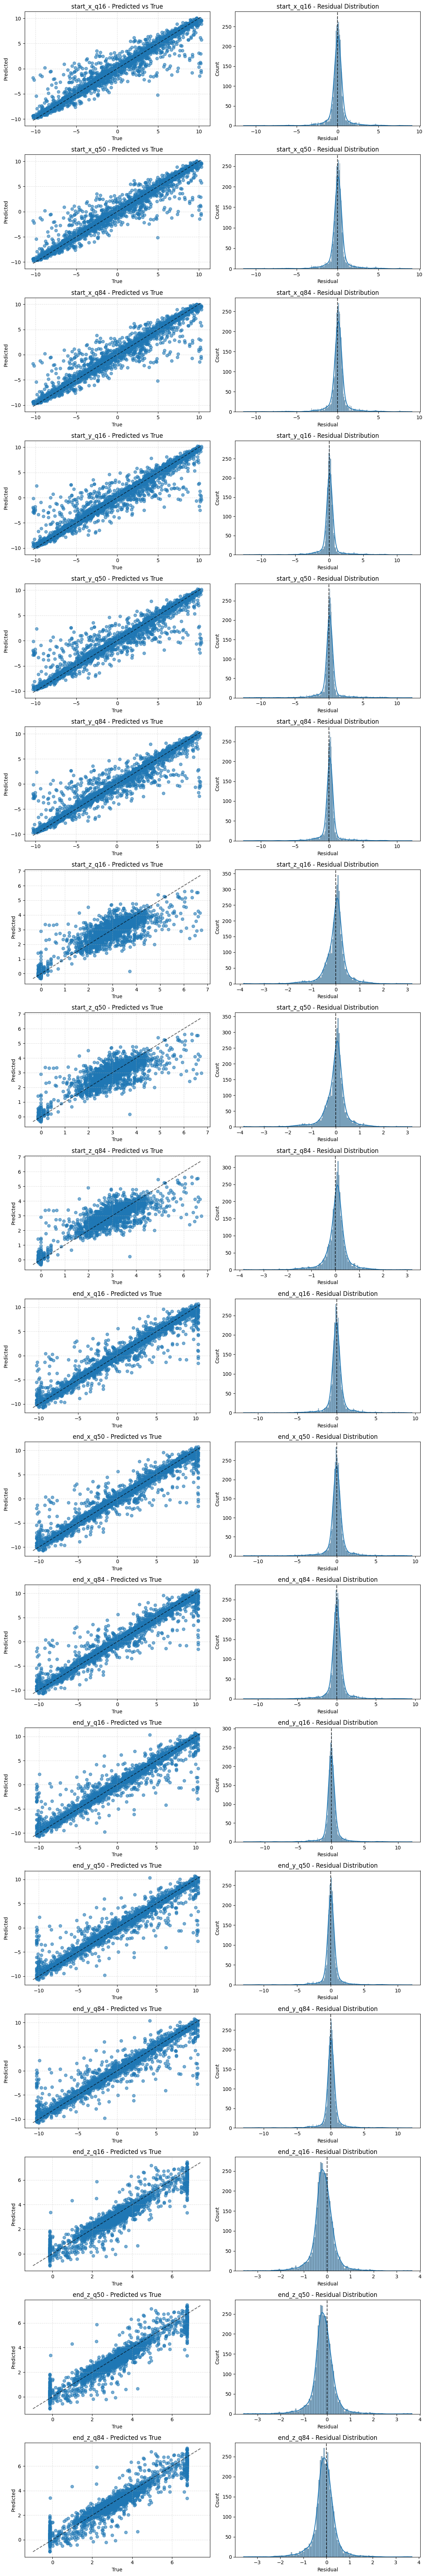

'/workspace/artifacts/validation_plots/endpoint_regressor/endpoint_regressor_20260218_235223_regression_diagnostics.png'

In [7]:
plot_regression_diagnostics(
    predictions=pred_np,
    targets=tgt_np,
    component_names=component_names,
    save_path=plots_dir / f"{plot_prefix}_regression_diagnostics.png",
    show=True,
)


### Regression Diagnostics By Quantile

These per-quantile panels make it explicit that the model emits separate outputs for `q16`, `q50`, and `q84`.


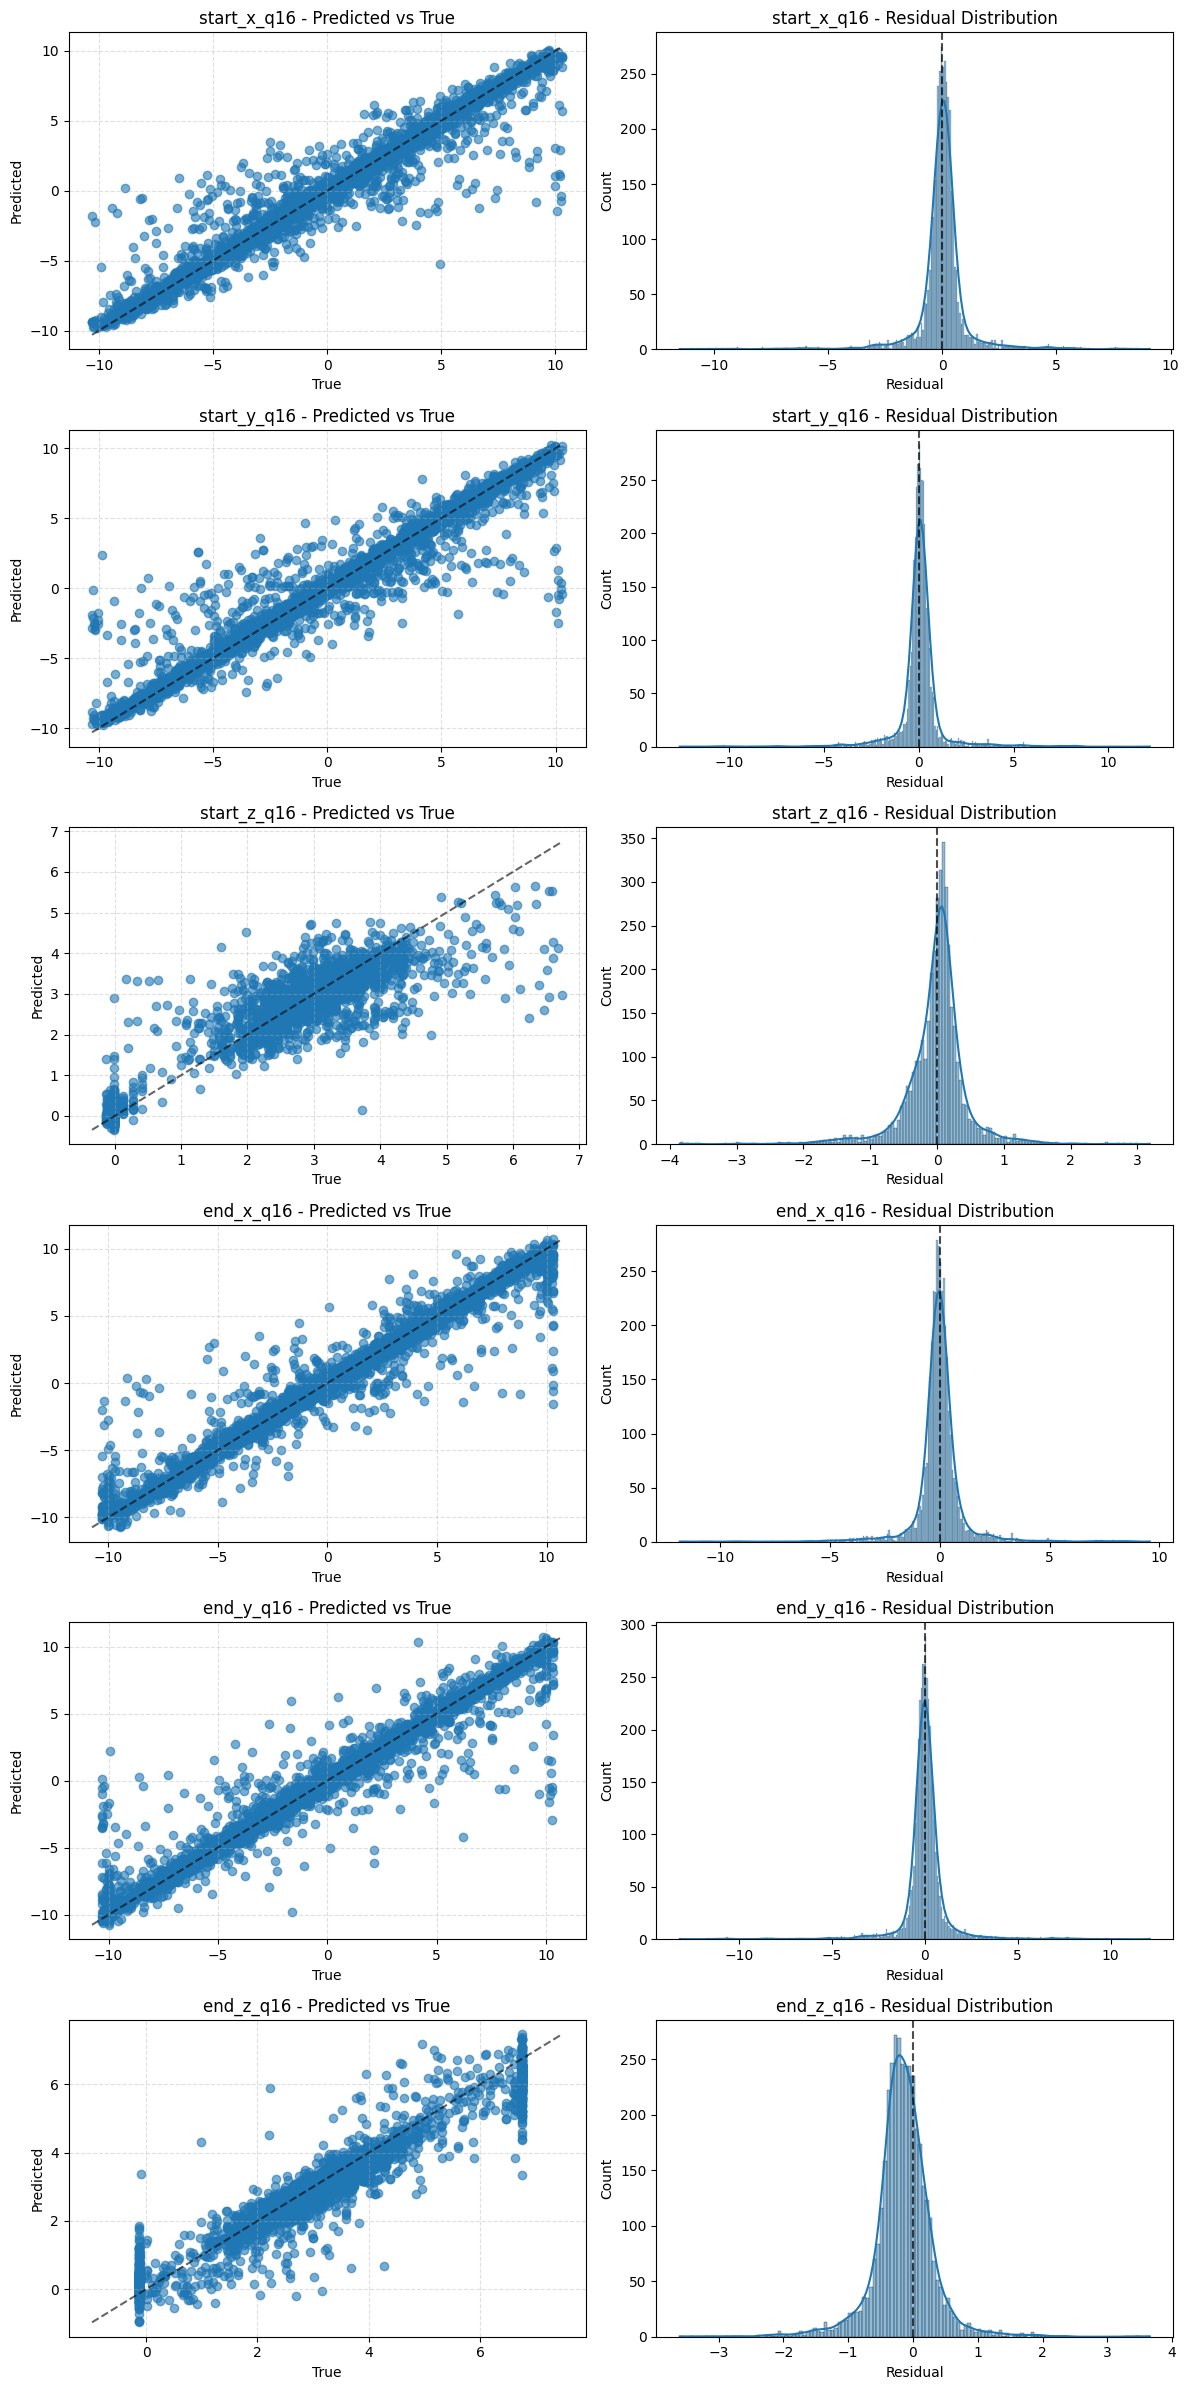

Saved quantile regression diagnostics for q16 (q=0.16).


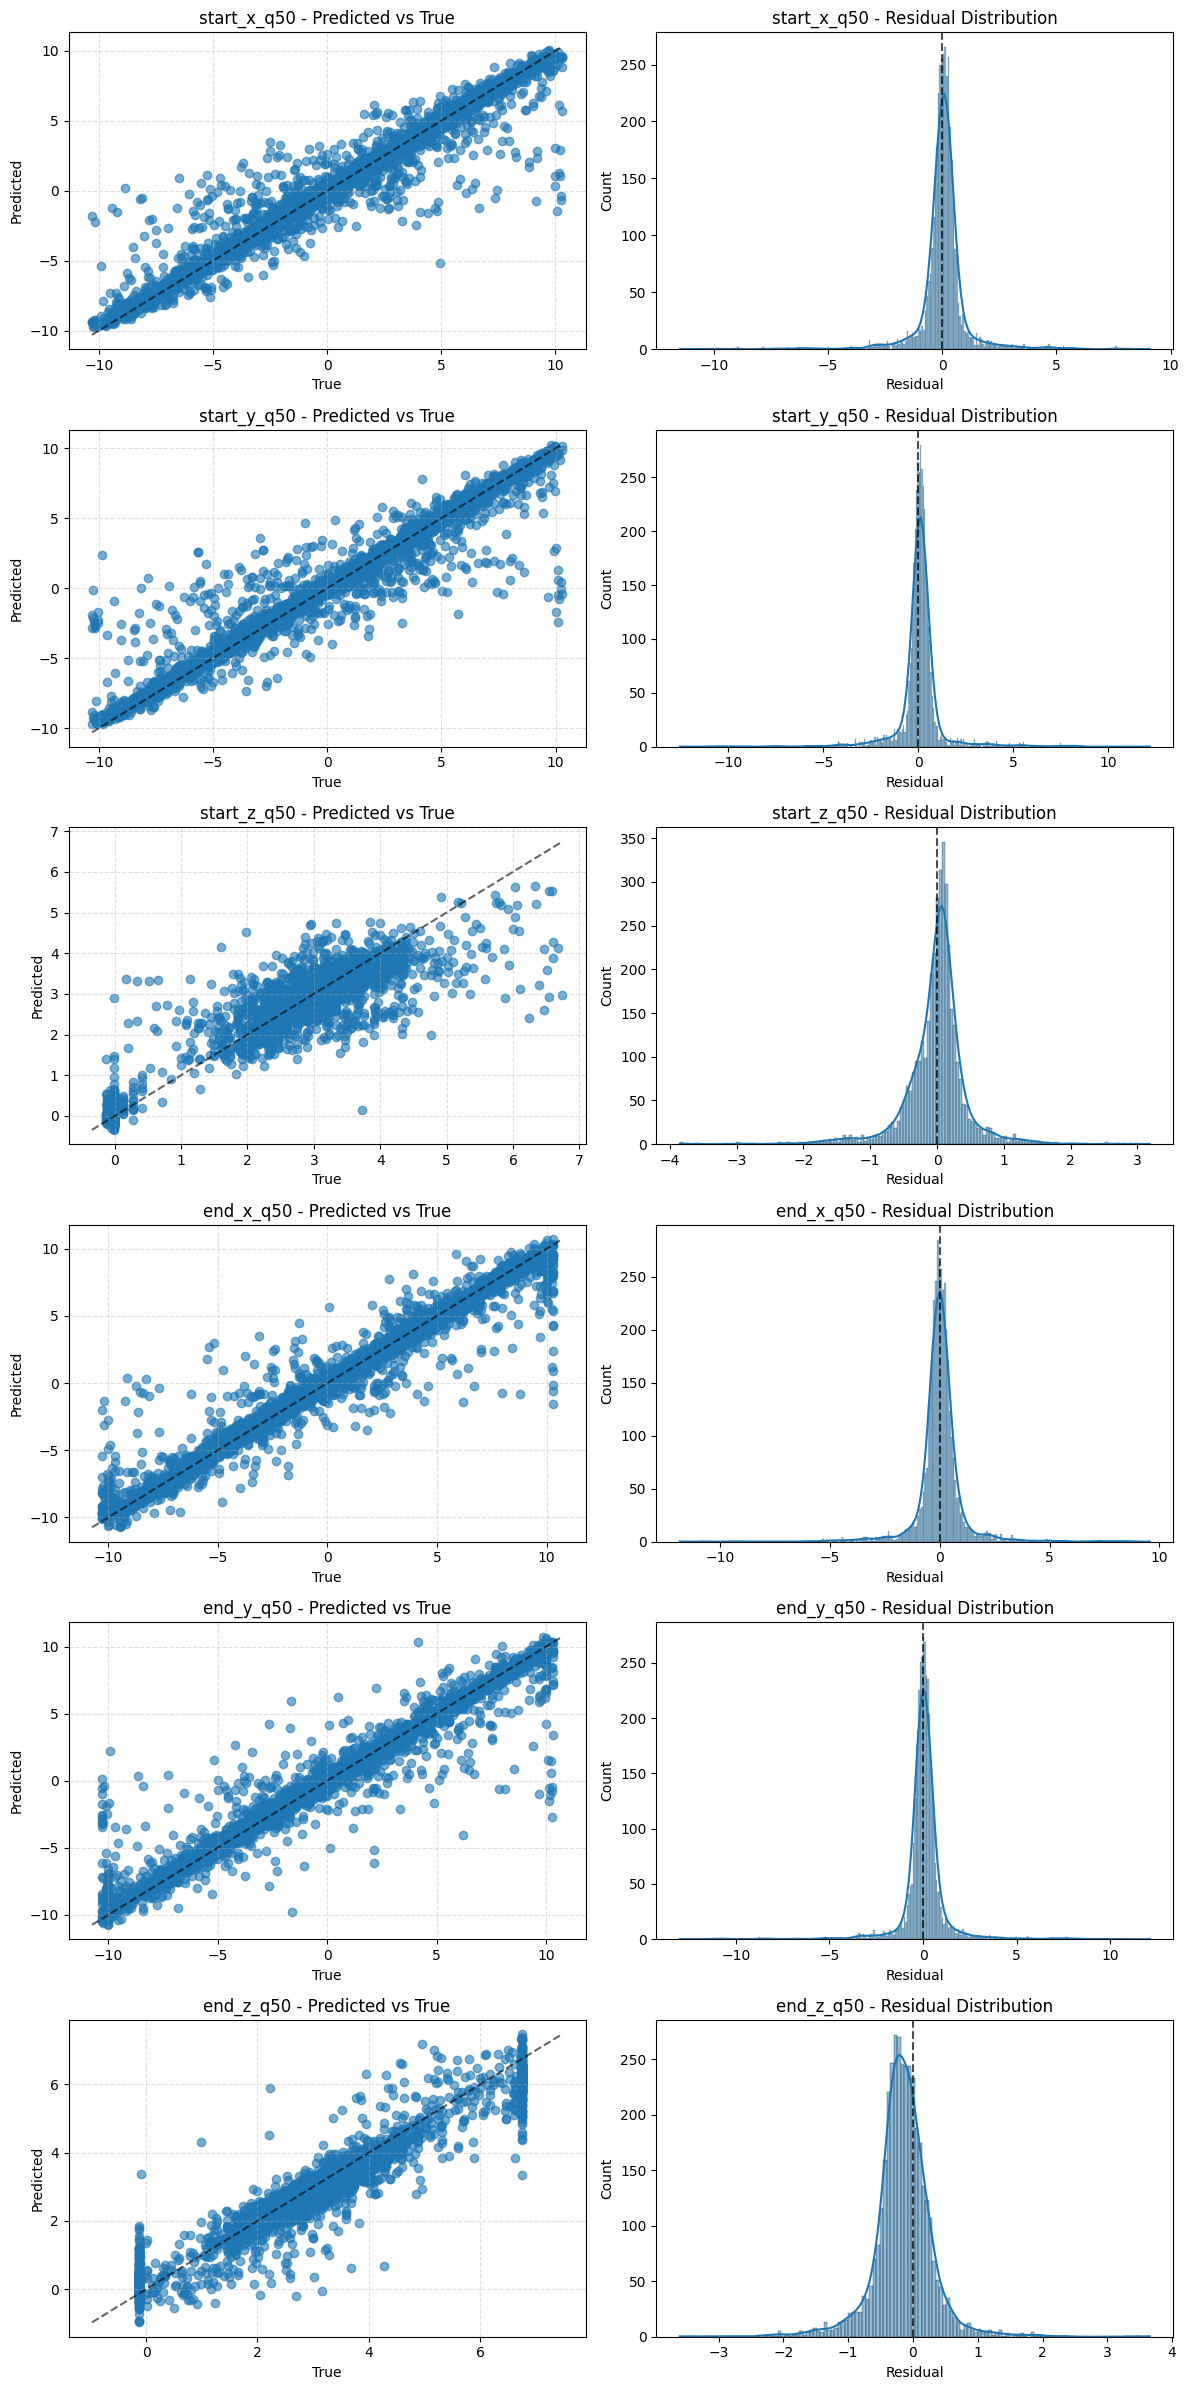

Saved quantile regression diagnostics for q50 (q=0.50).


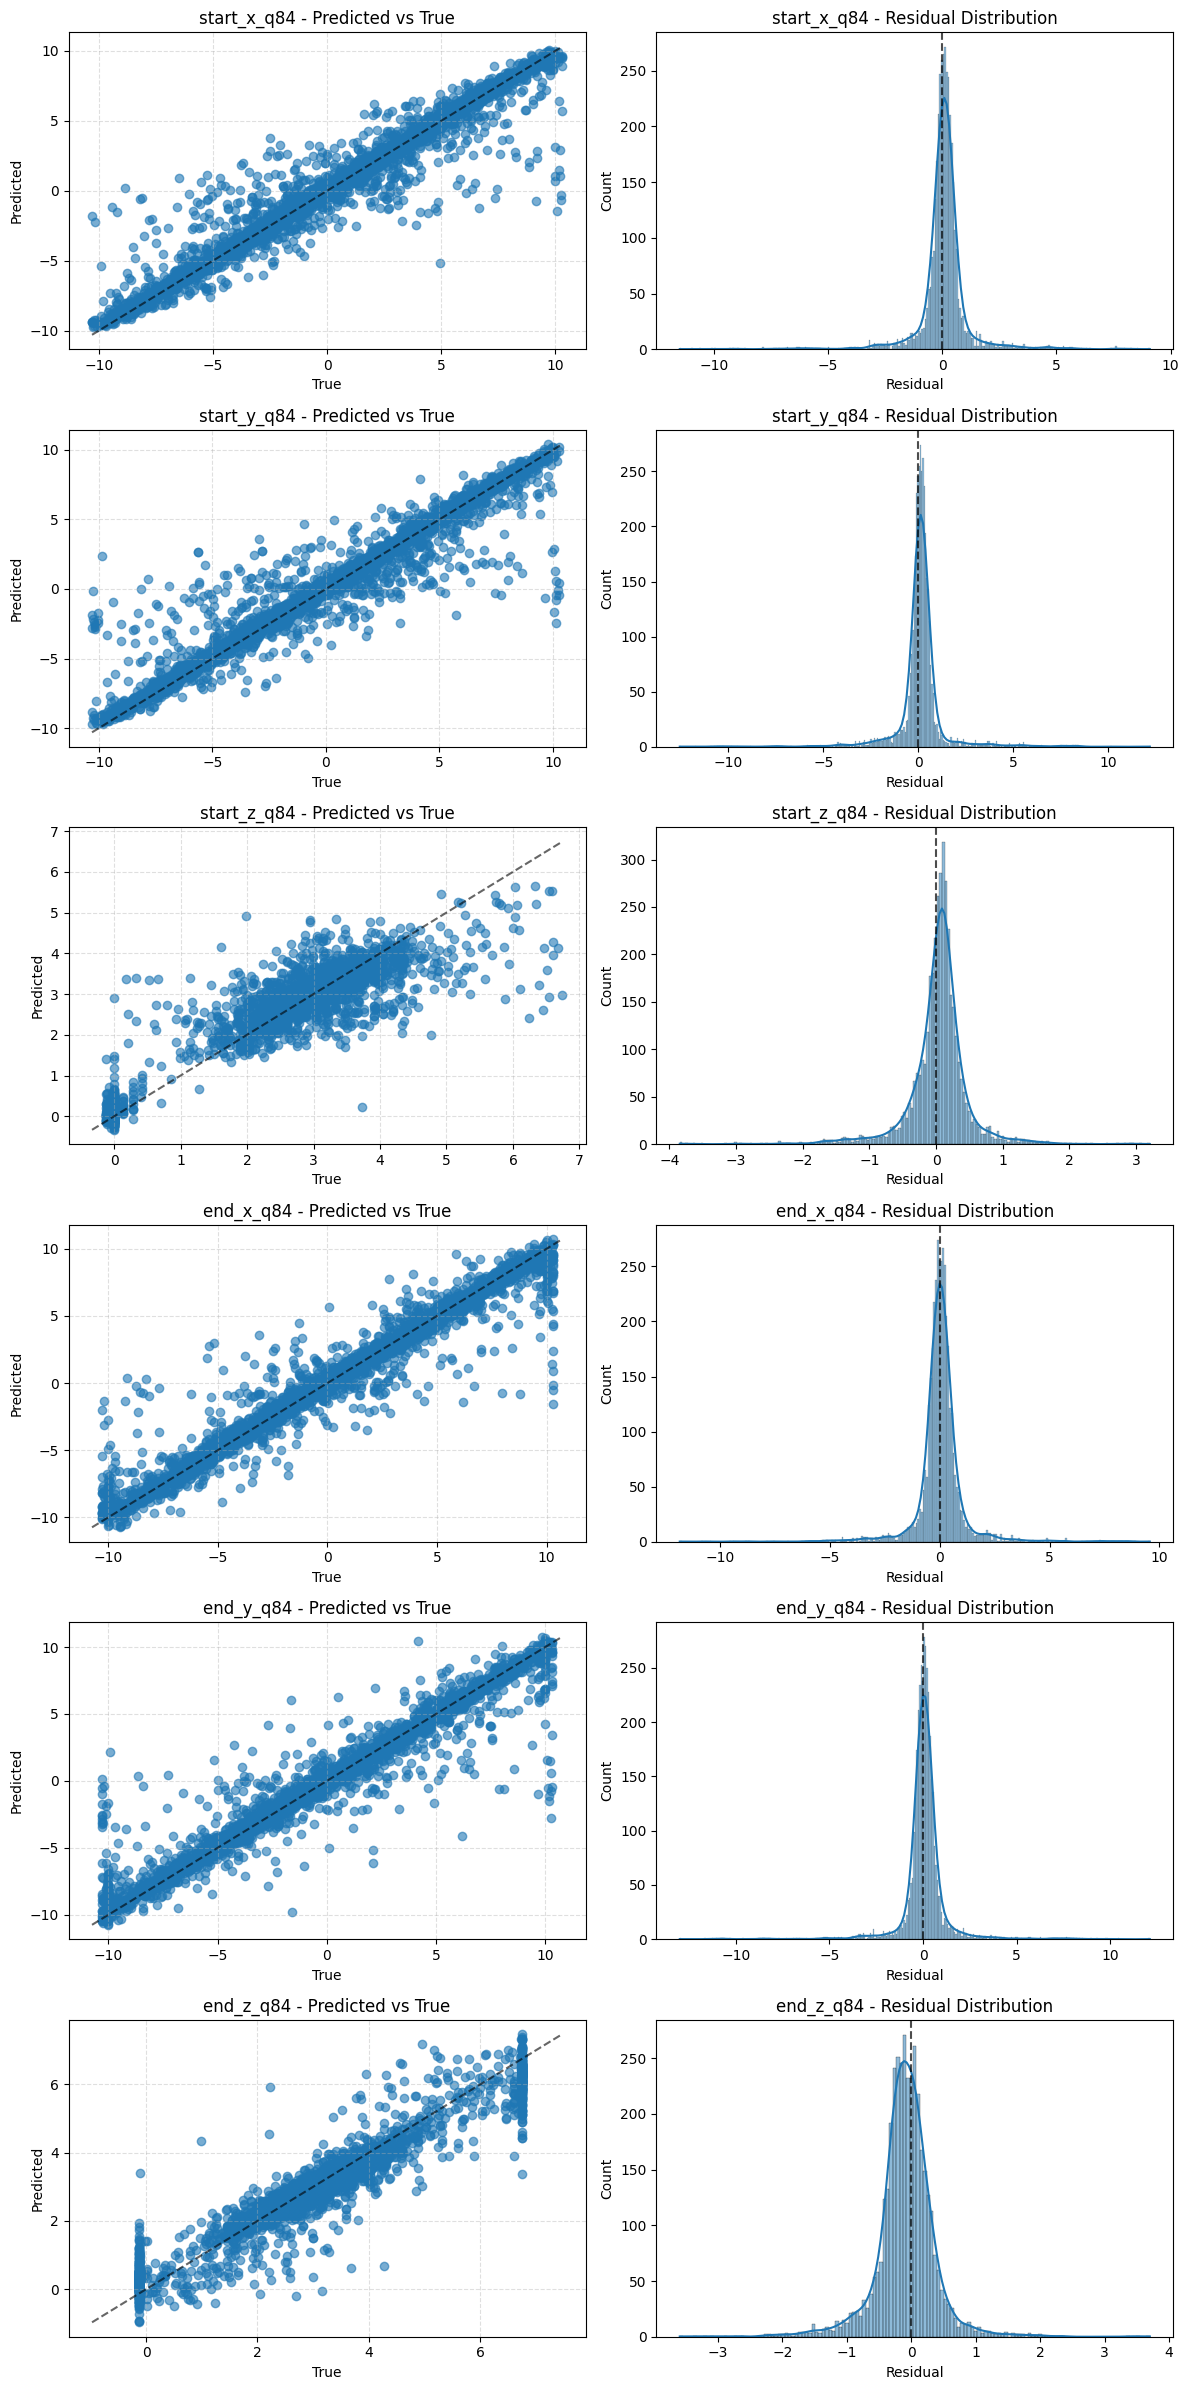

Saved quantile regression diagnostics for q84 (q=0.84).


In [8]:
quantile_component_names = {
    q: [f"{name}_{q}" for name in point_coord_names]
    for q in quantile_labels
}

for q_idx, q_name in enumerate(quantile_labels):
    q_level = float(quantile_levels[q_idx])
    pred_q = pred_quant[..., q_idx].reshape(pred_quant.shape[0], -1)
    tgt_q = tgt_quant[..., q_idx].reshape(tgt_quant.shape[0], -1)

    plot_regression_diagnostics(
        predictions=pred_q,
        targets=tgt_q,
        component_names=quantile_component_names[q_name],
        save_path=plots_dir / f"{plot_prefix}_regression_diagnostics_{q_name}.png",
        show=True,
    )
    print(f"Saved quantile regression diagnostics for {q_name} (q={q_level:.2f}).")


### Euclidean Error By Quantile (Start and End Points)

Euclidean error is computed independently for each quantile output, with explicit labels.


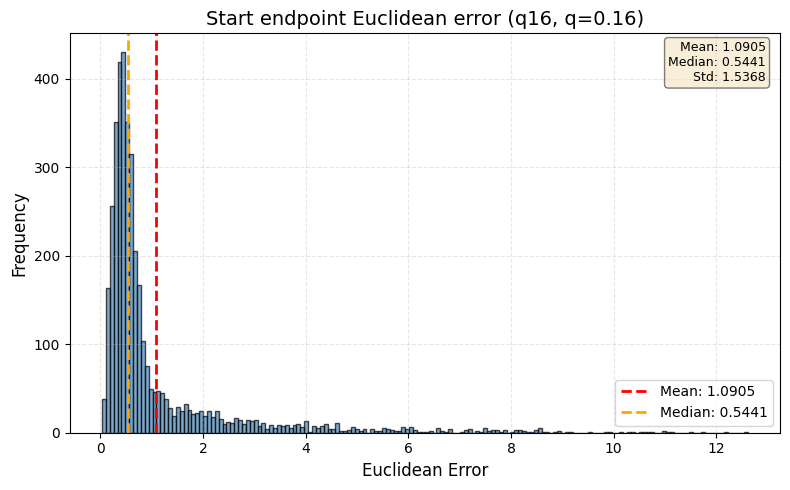

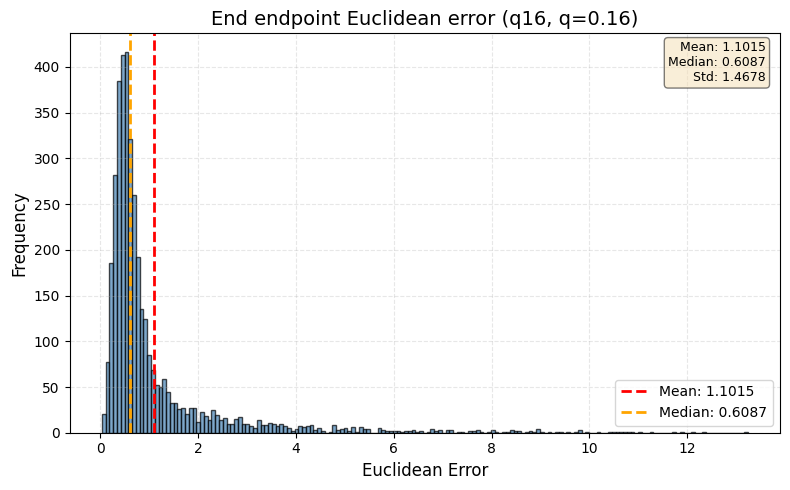

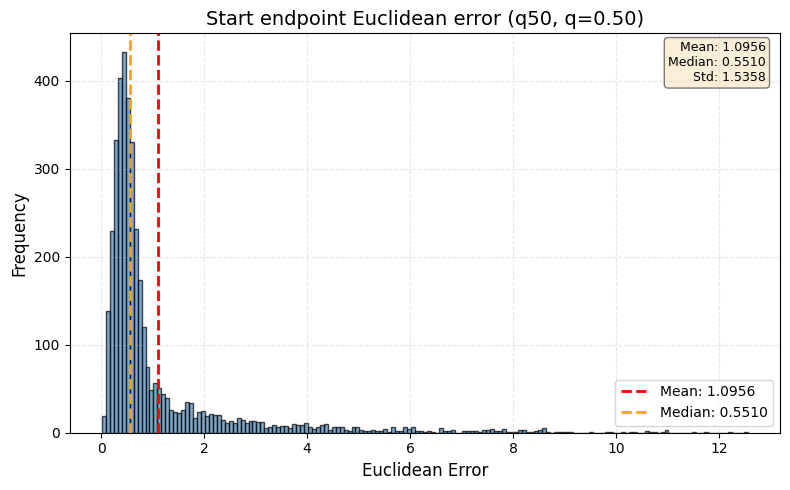

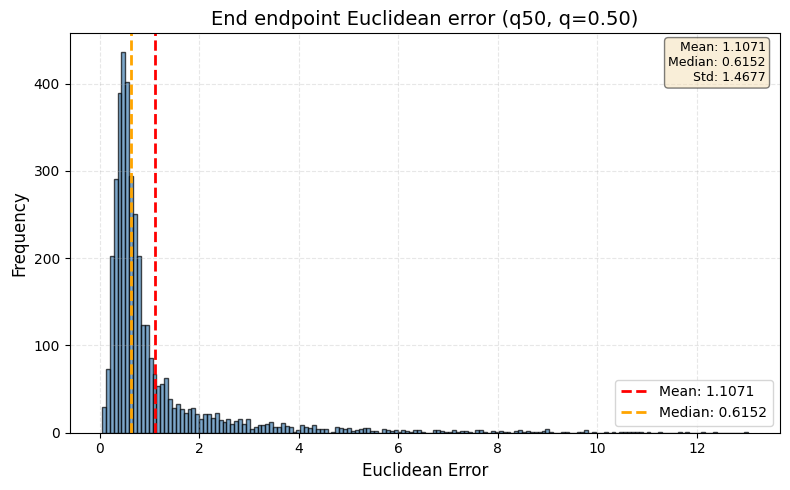

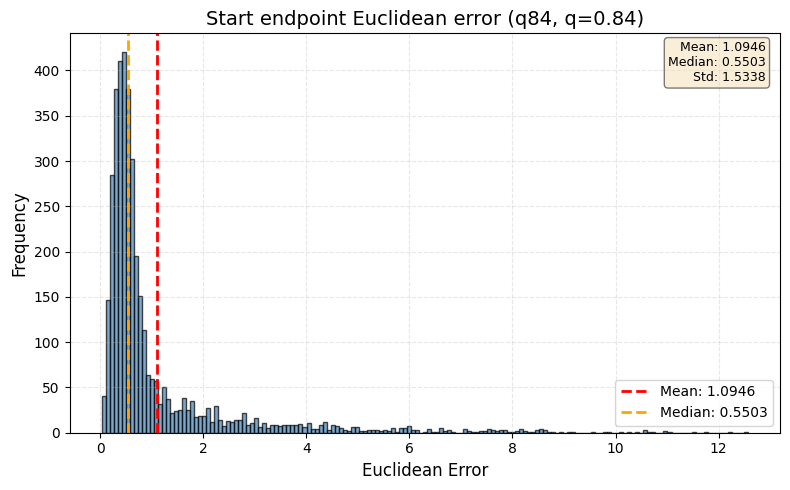

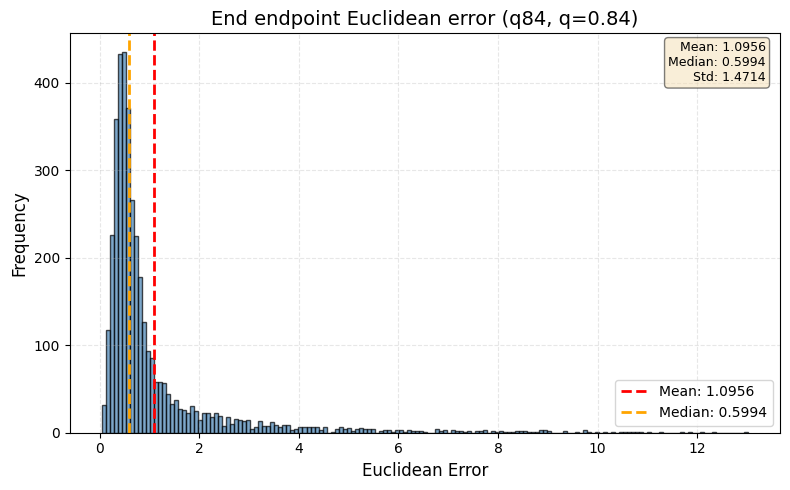

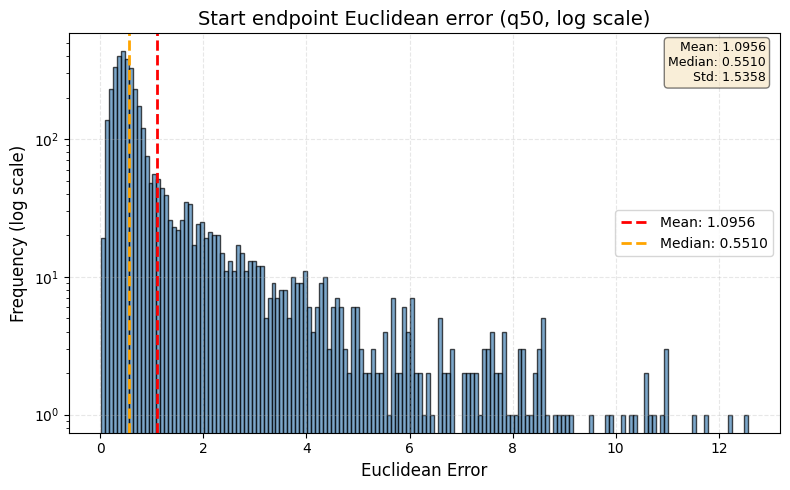

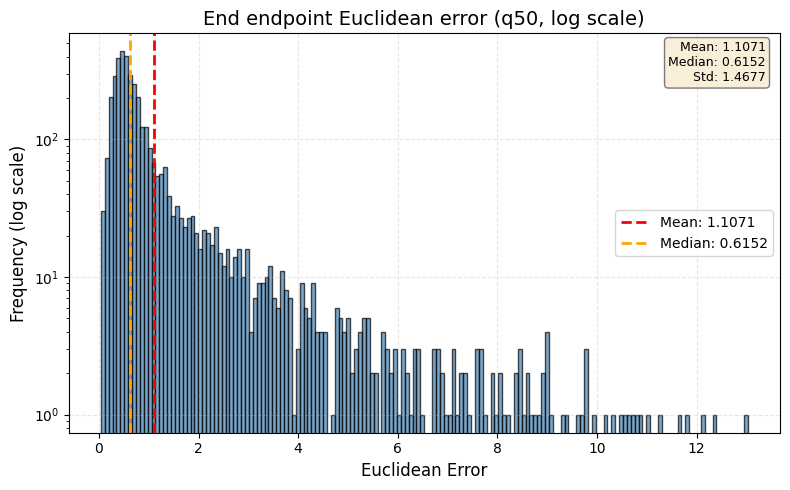

In [9]:
for q_idx, q_name in enumerate(quantile_labels):
    q_level = float(quantile_levels[q_idx])
    start_pred_q = pred_quant[:, 0, :, q_idx]
    start_true_q = tgt_quant[:, 0, :, q_idx]
    end_pred_q = pred_quant[:, 1, :, q_idx]
    end_true_q = tgt_quant[:, 1, :, q_idx]

    plot_euclidean_error_histogram(
        predictions=start_pred_q,
        targets=start_true_q,
        log_scale=False,
        title=f"Start endpoint Euclidean error ({q_name}, q={q_level:.2f})",
        save_path=plots_dir / f"{plot_prefix}_start_error_hist_{q_name}.png",
        show=True,
    )
    plot_euclidean_error_histogram(
        predictions=end_pred_q,
        targets=end_true_q,
        log_scale=False,
        title=f"End endpoint Euclidean error ({q_name}, q={q_level:.2f})",
        save_path=plots_dir / f"{plot_prefix}_end_error_hist_{q_name}.png",
        show=True,
    )

# Keep log-scale histograms for q50 as a reference view.
if "q50" in quantile_labels:
    q50_idx = quantile_labels.index("q50")
    start_pred = pred_quant[:, 0, :, q50_idx]
    start_true = tgt_quant[:, 0, :, q50_idx]
    end_pred = pred_quant[:, 1, :, q50_idx]
    end_true = tgt_quant[:, 1, :, q50_idx]

    plot_euclidean_error_histogram(
        predictions=start_pred,
        targets=start_true,
        log_scale=True,
        title="Start endpoint Euclidean error (q50, log scale)",
        save_path=plots_dir / f"{plot_prefix}_start_error_hist_q50_log.png",
        show=True,
    )
    plot_euclidean_error_histogram(
        predictions=end_pred,
        targets=end_true,
        log_scale=True,
        title="End endpoint Euclidean error (q50, log scale)",
        save_path=plots_dir / f"{plot_prefix}_end_error_hist_q50_log.png",
        show=True,
    )


### Error Embedding Space By Quantile

Each quantile output is projected to 2D separately and colored by endpoint error magnitude.


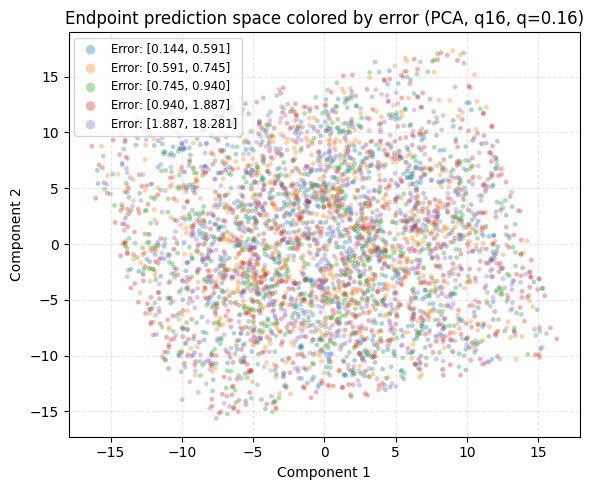

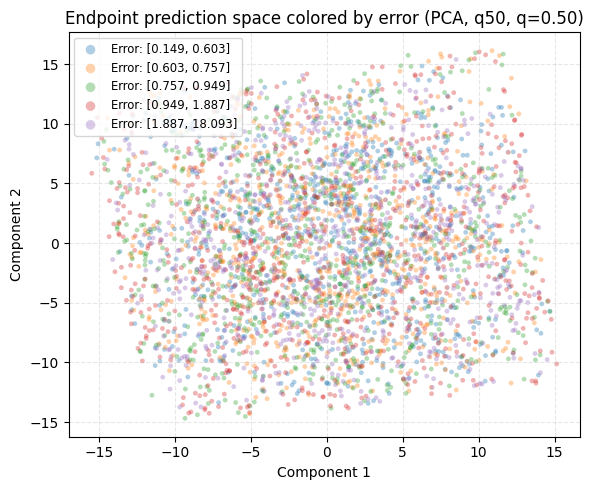

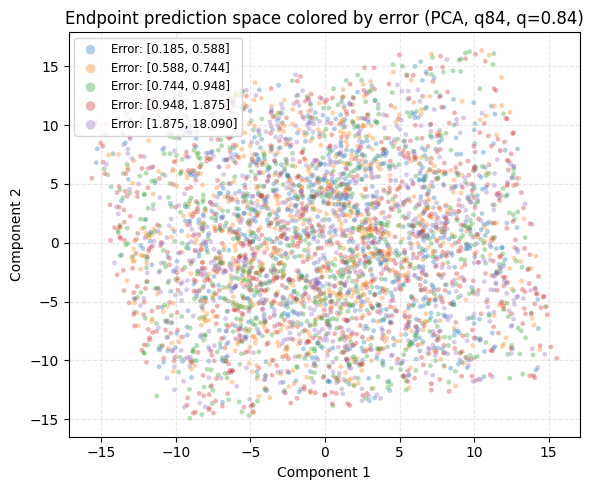

Saved validation plots to: /workspace/artifacts/validation_plots/endpoint_regressor


In [10]:
for q_idx, q_name in enumerate(quantile_labels):
    q_level = float(quantile_levels[q_idx])
    flat_pred = pred_quant[..., q_idx].reshape(pred_quant.shape[0], -1)
    flat_tgt = tgt_quant[..., q_idx].reshape(tgt_quant.shape[0], -1)

    plot_error_embedding_space(
        embeddings=flat_pred,
        predictions=flat_pred,
        targets=flat_tgt,
        method="pca",
        n_components=2,
        random_state=42,
        title=f"Endpoint prediction space colored by error (PCA, {q_name}, q={q_level:.2f})",
        max_samples=8000,
        save_path=plots_dir / f"{plot_prefix}_error_embedding_pca_{q_name}.png",
        show=True,
    )

print(f"Saved validation plots to: {plots_dir}")


## Optional: Read Saved Metrics

Read `metrics_latest.json` from the endpoint prediction output directory if present.


In [11]:
metrics_path = export_info.get("metrics_path")
if metrics_path is None:
    print("metrics_path: <not found>")
else:
    metrics_path = Path(metrics_path)
    print("metrics_path:", metrics_path)
    print(json.dumps(json.loads(metrics_path.read_text()), indent=2))


metrics_path: /workspace/data/endpoint_regressor/metrics_latest.json
{
  "loss": null,
  "mae": null,
  "mode": "endpoint_regressor",
  "model_path": "/workspace/trained_models/endpoint_regressor/endpoint_regressor_20260218_235111_torchscript.pt",
  "output_path": "/workspace/data/endpoint_regressor/ml_output_000_preds.parquet",
  "output_paths": [
    "/workspace/data/endpoint_regressor/ml_output_000_preds.parquet"
  ],
  "prediction_dim": 18,
  "validated_files": [
    "/workspace/data/ml_output_000.parquet"
  ],
  "validated_group_probs_files": [
    "/workspace/data/group_classifier/ml_output_000_preds.parquet"
  ],
  "validated_group_splitter_files": [
    "/workspace/data/group_splitter/ml_output_000_preds.parquet"
  ]
}
